pip install numpy  
pip install pandas  
pip install openpyxl  
pip install tqdm
pip install ffmpeg  
pip install pydub  
conda install -c conda-forge librosa  
pip install -U praat-parselmouth
pip install lime

In [1]:
import pydub
import pandas as pd
from tqdm import tqdm
import os

pydub.AudioSegment.converter = r"C:/Users/Kinza/anaconda3/envs/pie/Library/bin/ffmpeg.exe" #CHANGE THIS

# Data loading

In [2]:
from utils import get_end_from_start, get_start_end_from_file
from audio_feats_extract import load_audio

def load_audios(video_folder,startend_file) :
    '''Loads the audios from each interview question.
    Arguments:
        video_folder : str. The name of the folder containing mp4 videos.
        startend_file : str. The name of the file containing the video informations. 
            Must contain columns 'mail' and 'time'.
    Returns a list of audios
    '''
    filenames = tqdm(os.listdir(video_folder))
    df_startend = get_start_end_from_file(startend_file)
    audios = list(map(lambda f : load_audio(video_folder,df_startend,f), filenames))
    return [item for sublist in audios for item in sublist]

In [4]:
video_folder = 'videos/'
df_name = 'notes_entretiens_all.xlsx'

audios = load_audios(video_folder,df_name)

  0%|          | 0/25 [00:00<?, ?it/s]

alexis.przybylak@student.isae-supaero.fr.mp4


  4%|▍         | 1/25 [01:20<32:03, 80.14s/it]

anna.gounot@student.isae-supaero.fr.mp4


  8%|▊         | 2/25 [02:46<32:11, 83.96s/it]

basile.rochut@student.isae-supaero.fr.mp4


 12%|█▏        | 3/25 [03:35<24:56, 68.02s/it]

boudabousarah@gmail.com.mp4


 16%|█▌        | 4/25 [03:46<15:56, 45.56s/it]

clemi.petin@hotmail.fr.mp4


 20%|██        | 5/25 [05:01<18:43, 56.17s/it]

coop.pierre@gmail.com.mp4


 24%|██▍       | 6/25 [05:49<16:48, 53.09s/it]

Guillaume.de-battisti@student.isae-supaero.fr.mp4


 28%|██▊       | 7/25 [06:54<17:05, 56.99s/it]

heronheloise@outlook.fr.mp4


 32%|███▏      | 8/25 [07:07<12:12, 43.07s/it]

Hugo.SANCHEZ@student.isae-supaero.fr.mp4


 36%|███▌      | 9/25 [08:06<12:47, 47.98s/it]

khadija.kasmi@me.com.mp4


 40%|████      | 10/25 [09:10<13:15, 53.01s/it]

laura.hyest@student.isae-supaero.fr.mp4


 44%|████▍     | 11/25 [10:10<12:53, 55.28s/it]

laurine.meunier18@gmail.com.mp4


 48%|████▊     | 12/25 [10:54<11:12, 51.75s/it]

maloserra.p@gmail.com.mp4


 52%|█████▏    | 13/25 [11:42<10:07, 50.65s/it]

marine.de-la-fontaine-de-fontenay-le-lievre-de@student.isae-supaero.fr.mp4


 56%|█████▌    | 14/25 [12:39<09:36, 52.43s/it]

matilde.accorsi@univ-tlse3.fr.mp4


 60%|██████    | 15/25 [13:20<08:11, 49.16s/it]

melekbenmosbah@gmail.com.mp4


 64%|██████▍   | 16/25 [14:08<07:18, 48.68s/it]

merhabencyrine@gmail.com.mp4


 68%|██████▊   | 17/25 [15:24<07:35, 56.99s/it]

mouillelucie@orange.fr.mp4


 72%|███████▏  | 18/25 [17:20<08:42, 74.69s/it]

Pierre-antoine.DRICOT@student.isae-supaero.fr.mp4


 76%|███████▌  | 19/25 [18:18<06:58, 69.79s/it]

pro.kaiskasmi@gmail.com.mp4


 80%|████████  | 20/25 [18:49<04:50, 58.11s/it]

Quentin.PRIETO@student.isae-supaero.fr.mp4


 84%|████████▍ | 21/25 [20:00<04:07, 61.82s/it]

sophie.bonte@student.isae-supaero.fr.mp4


 88%|████████▊ | 22/25 [21:27<03:27, 69.33s/it]

thomas.sentucq@student.isae-supaero.fr.mp4


 92%|█████████▏| 23/25 [22:16<02:06, 63.29s/it]

thomas.sentucq@student.isae-supaero.fr1.mp4


 96%|█████████▌| 24/25 [23:05<00:59, 59.00s/it]

Titouan.DELLIS@student.isae-supaero.fr.mp4


100%|██████████| 25/25 [23:50<00:00, 57.20s/it]


# Load features

In [38]:
from data import get_features, get_scores, merge_scores_feats

feats = get_features(audios)

In [40]:
feats.to_csv('feats.csv')

In [3]:
import pandas as pd
feats = pd.read_csv('feats.csv')
feats = feats.set_index('id')

# Visualizations

In [4]:
import ipywidgets as widgets
from ipywidgets import Layout

interview = widgets.Select(
    options = feats.index.tolist(),
    description='Interview',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)

variable = widgets.Select(
    options = feats.columns.tolist(),
    description='Variable',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_boxplot(interview,variable):
    var = round(feats.loc[interview,variable],3)

    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(y=variable, data=feats)
    ax.axhline(var,c='r')

    plt.text(-0.3, var*1.005, var, horizontalalignment='left', size='small', color='red', weight='normal')

widgets.interactive(print_boxplot,interview=interview,variable=variable)

interactive(children=(Select(description='Interview', layout=Layout(display='flex', height='80px', width='50%'…

# Scores and features processing

In [6]:
parole = ['Q1','Q2','Q4']
texte = ['Q5','Q6']
visuel = ['Q3','Q7','Q8','Q21']
discours = ['Q9','Q10','Q11','Q13','Q17']
motivation = ['Q14','Q15']
impression = ['Q12','Q16','Q18','Q19','Q20']

In [7]:
from data import get_scores, merge_scores_feats
    
df_name = 'notes_entretiens_all.xlsx'

scores = get_scores(df_name)

feats, scores = merge_scores_feats(scores,feats)

<AxesSubplot:>

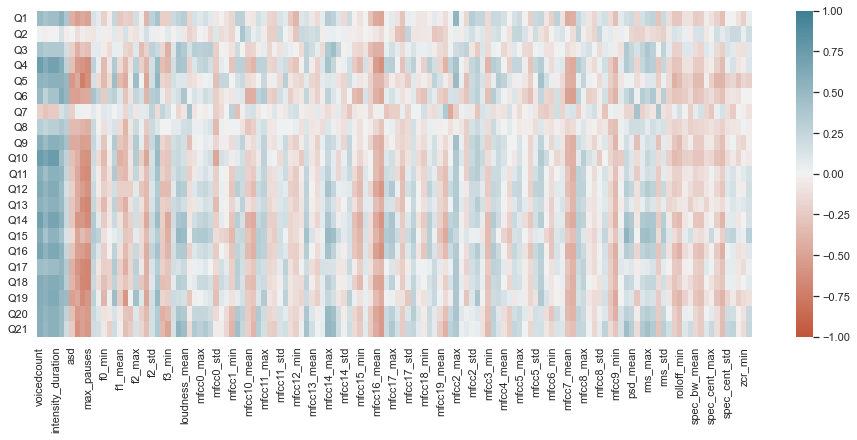

In [8]:
import seaborn as sns
cormat = pd.concat([feats, scores], axis=1).corr()

cormat = cormat.loc[scores.columns,feats.columns]

plt.figure(figsize=(16, 6))
sns.heatmap(cormat, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, n=200))

In [9]:
cormat[abs(cormat)>0.6].dropna(axis=0,how='all').dropna(axis=1,how='all')

,voicedcount,npause,originaldur,intensity_duration,speakingrate,nb_pauses,mean_pauses,max_pauses,mfcc16_min
Q4,0.720463,NaN,0.691656,0.691656,NaN,NaN,NaN,-0.630739,-0.628030
Q5,NaN,NaN,NaN,NaN,NaN,NaN,-0.729641,-0.619256,NaN
Q6,NaN,NaN,NaN,NaN,0.607529,NaN,NaN,NaN,NaN
Q10,0.733834,0.6684,0.742718,0.742718,NaN,NaN,NaN,-0.608842,NaN
Q11,NaN,NaN,NaN,NaN,NaN,NaN,-0.622471,-0.641534,NaN
Q12,0.619109,NaN,0.605115,0.605115,NaN,NaN,NaN,-0.601279,NaN
Q13,NaN,NaN,NaN,NaN,NaN,NaN,-0.639213,-0.675391,NaN
Q14,0.700367,NaN,0.671182,0.671182,NaN,NaN,NaN,-0.642733,NaN
Q15,0.606280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q16,0.664425,NaN,0.634176,0.634176,NaN,NaN,NaN,-0.605957,-0.606398


In [20]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test = train_test_split(feats,scores,test_size=0.2, random_state=42)

parole = ['Q1','Q2','Q4']
texte = ['Q5','Q6']
visuel = ['Q3','Q7','Q8','Q21']
discours = ['Q9','Q10','Q11','Q13','Q17']
motivation = ['Q14','Q15']
impression = ['Q12','Q16','Q18','Q19','Q20']
best_scores = parole+texte+visuel+discours+motivation+impression

mse = []
model = RandomForestRegressor()
for q in best_scores:
    y_tr = y_train[q]
    y_te = y_test[q]

    model.fit(X_train,y_tr)
    mse.append(mean_squared_error(model.predict(X_test),y_te))

Text(0.5, 0, 'MSE')

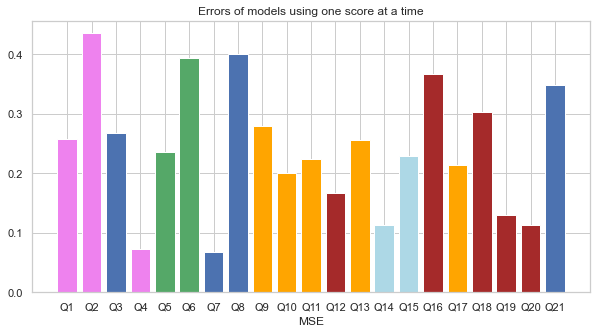

In [21]:
def color(c):
    if c in parole:
        return 'violet'
    elif c in texte:
        return 'g'
    elif c in visuel:
        return 'b'
    elif c in discours:
        return 'orange'
    elif c in motivation:
        return 'lightblue'
    else:
        return 'brown'
    
colors = pd.DataFrame()
colors['column'] = ['Q'+str(i+1) for i in range(len(best_scores))]
colors['col'] = colors.apply(lambda c: color(c.column),axis=1)

plt.figure(figsize=(10,5))
plt.bar(['Q'+str(i+1) for i in range(len(best_scores))],mse, color=colors['col'])
plt.title('Errors of models using one score at a time')
plt.xlabel('Question')
plt.xlabel('MSE')

Text(0.5, 0, 'MSE')

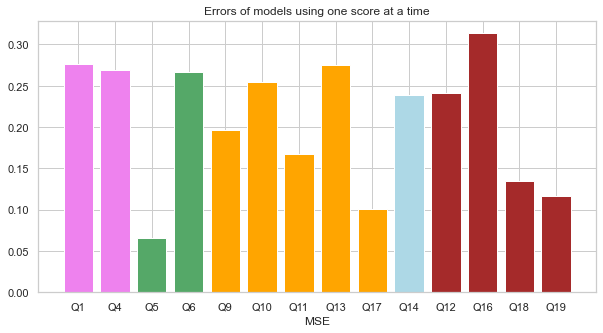

In [22]:
parole = ['Q1','Q4']
texte = ['Q5','Q6']
visuel = []
discours = ['Q9','Q10','Q11','Q13','Q17']
motivation = ['Q14']
impression = ['Q12','Q16','Q18','Q19']
best_scores = parole+texte+visuel+discours+motivation+impression

colors = pd.DataFrame()
colors['column'] = best_scores
colors['col'] = colors.apply(lambda c: color(c.column),axis=1)

X_train, X_test, y_train, y_test = train_test_split(feats,scores[best_scores],test_size=0.2, random_state=42)

mse = []
model = RandomForestRegressor()
for q in best_scores:
    y_tr = y_train[q]
    y_te = y_test[q]

    model.fit(X_train,y_tr)
    mse.append(mean_squared_error(model.predict(X_test),y_te))

plt.figure(figsize=(10,5))
plt.bar(best_scores,mse, color=colors['col'])
plt.title('Errors of models using one score at a time')
plt.xlabel('Question')
plt.xlabel('MSE')

# One label classification/regression

In [39]:
import numpy as np
score = scores.mean(axis=1)

X_train, X_test, y_train, y_test = train_test_split(feats,score,test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train,y_train)

metric = mean_squared_error

print('train mse:',metric(model.predict(X_train),y_train))
print('test mse: ',metric(model.predict(X_test),y_test))

metric =  f1_score

print('train f1_score:',metric(model.predict(X_train).round(),y_train.round(),average='weighted'))
print('test f1_score: ',metric(model.predict(X_test).round(),y_test.round(),average='weighted'))

In [33]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(feats,score.round(),test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=1000,max_depth=10)
model.fit(X_train,y_train)

metric =  f1_score

print('train f1_score:',metric(model.predict(X_train),y_train,average='weighted'))
print('test f1_score: ',metric(model.predict(X_test),y_test,average='weighted'))

train f1_score: 1.0
test f1_score:  0.795


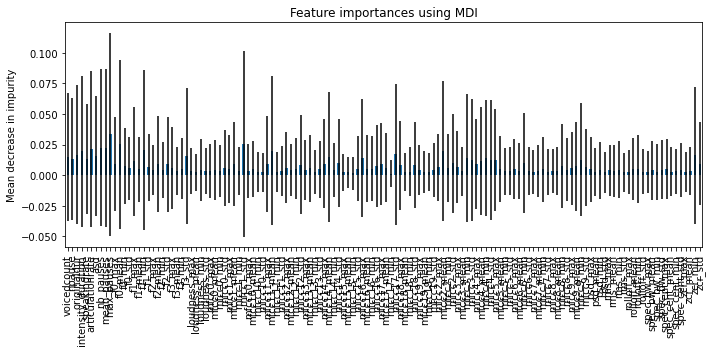

In [34]:
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feats.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [81]:
forest_importances.sort_values(ascending=False).head(15)

max_pauses          0.031497
f0_mean             0.026881
mean_pauses         0.024416
mfcc2_mean          0.021555
mfcc1_std           0.019298
nb_pauses           0.018019
asd                 0.017843
articulationrate    0.017647
f1_min              0.016475
speakingrate        0.015843
mfcc9_min           0.015160
voicedcount         0.014455
f3_std              0.014235
mfcc3_min           0.014113
f1_max              0.013361
dtype: float64

# Multilabel classification/regression

In [82]:
import numpy as np

score = scores.copy()
score['parole'] = score[parole].mean(axis=1)
score['texte'] = score[texte].mean(axis=1)
score['visuel'] = score[visuel].mean(axis=1)
score['discours'] = score[discours].mean(axis=1)
score['motivation'] = score[motivation].mean(axis=1)
score['impression'] = score[impression].mean(axis=1)
score['all'] = score.mean(axis=1)

score = score[['parole','texte','visuel','discours','motivation','impression','all']]


X_train, X_test, y_train, y_test = train_test_split(feats,score,test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=50,max_depth=50)
model.fit(X_train,y_train)

metric = mean_squared_error

print('train mse:',metric(model.predict(X_train),y_train))
print('test mse: ',metric(model.predict(X_test),y_test))

train mse: 0.026808849870781193
test mse:  0.15596552870069277


In [84]:
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

score = scores.copy()
score['parole'] = score[parole].mean(axis=1)
score['texte'] = score[texte].mean(axis=1)
score['visuel'] = score[visuel].mean(axis=1)
score['discours'] = score[discours].mean(axis=1)
score['motivation'] = score[motivation].mean(axis=1)
score['impression'] = score[impression].mean(axis=1)
score['all'] = score.mean(axis=1)

score = score[['parole','texte','visuel','discours','motivation','impression','all']]

X_train, X_test, y_train, y_test = train_test_split(feats,score.round(),test_size=0.2, random_state=42)

model = MultiOutputClassifier(RandomForestClassifier(n_estimators=50,max_depth=50))
model.fit(X_train,y_train)

metric =  f1_score

predictions = np.stack(model.predict(X_train))
print([metric(np.array(y_train)[:,i],predictions[:,i],average='weighted') for i in range(7)])
#roc_auc_score(np.stack(predictions),np.stack(y_train))

predictions = np.stack(model.predict(X_test))
print([metric(np.array(y_test)[:,i],predictions[:,i],average='weighted') for i in range(7)])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.44651442307692313, 0.6062500000000001, 0.7157738095238095, 0.6208333333333332, 0.3913043478260869, 0.7473262032085561, 0.8718944099378882]


# PCA

In [24]:
import hashlib
feats_pca = feats.copy()
feats_pca['email'] = list(map(lambda s : s.split('_')[0],feats_pca.index.values))
feats_pca['question'] = list(map(lambda s : s.split('_')[1],feats_pca.index.values))


feats_pca['email'] = list(map(lambda e : hashlib.md5(e.encode()).hexdigest()[:5],feats_pca.email))
feats_pca['email'] = feats_pca.apply(lambda s : s.email+'_'+s.question,axis=1)
feats_pca = feats_pca.set_index('email').drop(columns=['question'])
# Fit transform

#feats_pca = feats_pca.iloc[:,:30]

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [30] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


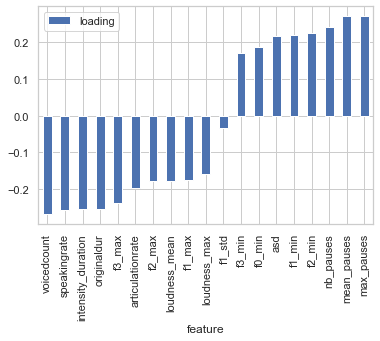

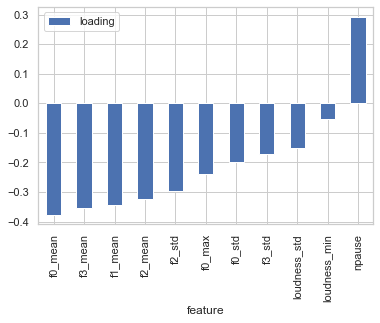

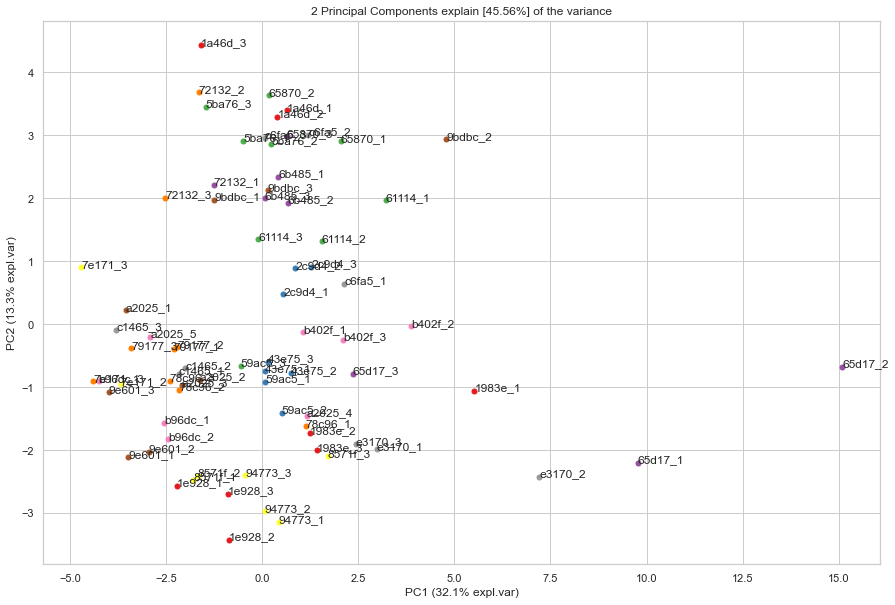

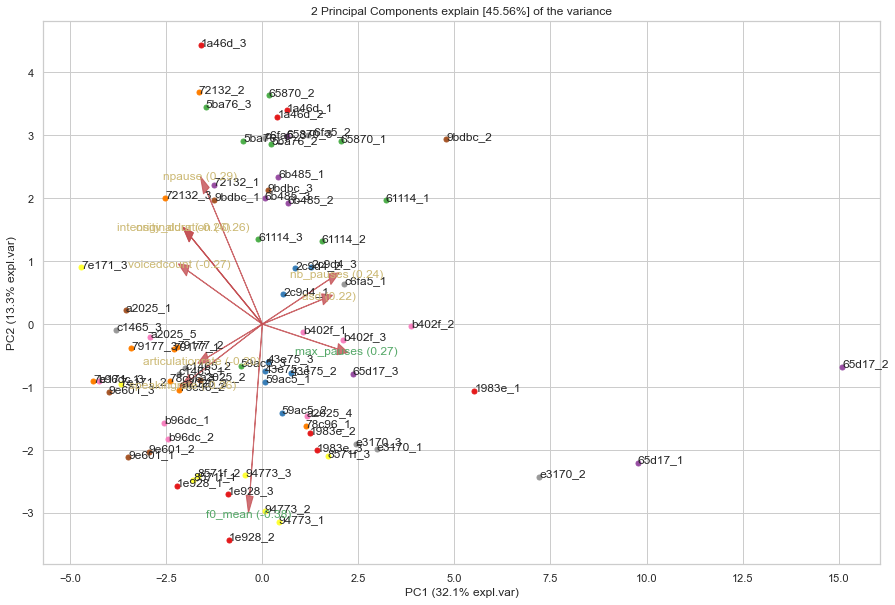

C:\Users\Kinza\AppData\Local\Temp\ipykernel_17964\965974525.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'PC2')

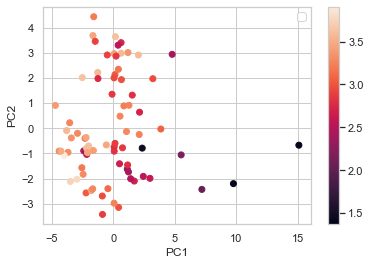

In [34]:
from pca import pca
import hashlib

score = scores.mean(axis=1)

pca_m = pca(n_components=2,normalize=True)

features_pca = pca_m.fit_transform(feats_pca.iloc[:,:30])

pca_m.compute_topfeat().sort_values('loading').groupby('PC').plot.bar('feature','loading')

# Scatter first 2 PCs
fig, ax = pca_m.scatter(legend=False)

# Make biplot with the number of features
fig, ax = pca_m.biplot(n_feat=10,legend=False,label=True)

import matplotlib.pyplot as plt
plt.scatter(features_pca['PC']['PC1'],features_pca['PC']['PC2'],c=score)
plt.colorbar()
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')